In [350]:
import torch
from sentence_transformers import SentenceTransformer
from model import SimpleContrastiveNetwork, ContrastiveLoss
from dataset import ContrastiveDataset
from torch.utils.data import DataLoader
import numpy as np
from util import set_seed

# model_name = 'best_models/best_cl_transform-gsm8k_cl_trans_para1_112_autosplit-b8-e50-lr0.000124-InfoNCE-lt0.30.pth'
# model_name = 'best_models/best_cl_transform-gsm8k_cl_trans_para1_112_autosplit-b8-e50-lr0.000251-InfoNCE-lt0.15.pth'
model_name = 'best_models/best_cl_transform-gsm8k_cl_trans_para1_112_autosplit-b8-e50-lr0.000450-InfoNCE-lt0.05.pth'
batch_size = 8
loss_temp = 0.05
dataset_csv = 'gsm8k_cl_trans_para1_112_autosplit.csv'
split = 'train'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SimpleContrastiveNetwork().to(device)
model.load_state_dict(torch.load(model_name))
model.eval()

set_seed(1)

In [351]:
np.random.seed(42)

# COMPARE ORIGINAL EMBEDDING LOSS TO TRANSFORMED EMBEDDINGS
sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
criterion = ContrastiveLoss(temperature=loss_temp, loss_type='InfoNCE')

the_dataset = ContrastiveDataset(csv_path=dataset_csv, sent_transformer=sent_transformer, split=split)
the_loader = DataLoader(the_dataset, batch_size=batch_size, shuffle=True)

total_original_loss = 0
total_transformed_loss = 0

for anchor_emb, positive_emb, negative_emb in the_loader:
    anchor_in = anchor_emb.to(device)
    positives_in = positive_emb.to(device)
    negatives_in = negative_emb.to(device)

    with torch.no_grad():
        anchor_out = model(anchor_in)
        positives_out = model(positives_in)
        negatives_out = model(negatives_in)

    original_loss = criterion(anchor_in, positives_in, negatives_in)
    transformed_loss = criterion(anchor_out, positives_out, negatives_out) 
    
    total_original_loss += original_loss.item()
    total_transformed_loss += transformed_loss.item()

avg_original_loss = total_original_loss / len(the_loader)
avg_transformed_loss = total_transformed_loss / len(the_loader)

print(f"{split.title()} Original Loss: {original_loss.item():.6f}, {split.title()} Transformed Loss: {transformed_loss.item():.6f}")

Train Original Loss: 0.656429, Train Transformed Loss: 0.001436


ANCHOR   (Sentence 1):  First, let's calculate the total number of glass bottles Kyle bought. He initially bought 2 bottles and then bought another 3 identical bottles, so he has a total of 2 + 3 = 5 bottles.
POSITIVE (Sentence 2):  First, we need to figure out the total number of jars Ava has. She initially got 2 jars and later got 3 more jars, which adds up to 2 + 3 = 5 jars.
NEGATIVE (Sentence 3):  Since each seed represents a tree, James planted 24 trees.
NEGATIVE (Sentence 4):  First, let's calculate how much Derek spends on his textbooks. He spends half of $960, which is $960/2 = $480.
NEGATIVE (Sentence 5):  Next, let's calculate how much money Derek has left after buying his textbooks. He had $960 and spent $480, so he has $960 - $480 = $480 left.


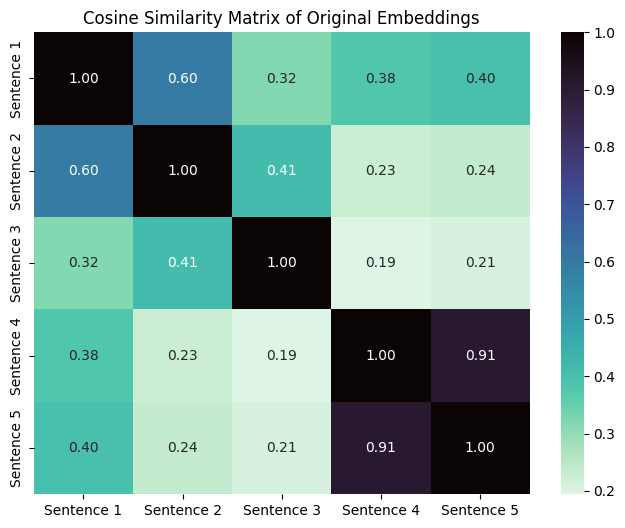

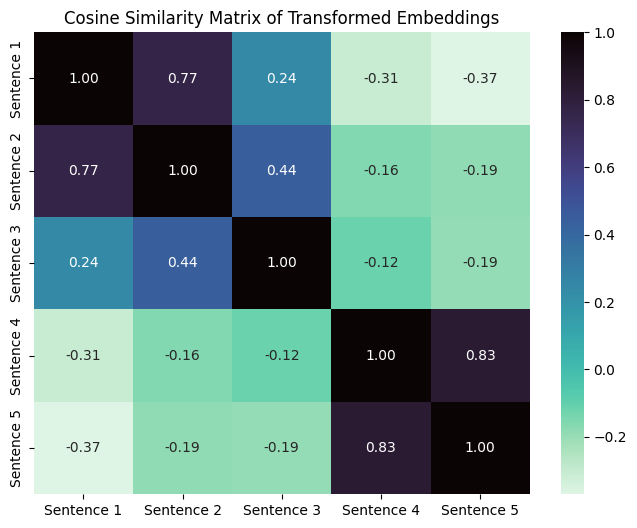

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import ast

df = pd.read_csv('data/gsm8k_cl_trans_para1_112_autosplit.csv')
df['Positive'] = df['Positive'].apply(ast.literal_eval)
df['Negative'] = df['Negative'].apply(ast.literal_eval)

rand_df = df.loc[df.split == 'val'].sample(1, random_state=33)

positiveEmb, negativeEmb = rand_df['Positive'].tolist()[0][:3], rand_df['Negative'].tolist()[0][:3]
print(f'ANCHOR   (Sentence 1): ', rand_df['Reasoning Trace'].tolist()[0])
print(f'POSITIVE (Sentence 2): ', positiveEmb[0])
# print(len(positiveEmb))
for i, negemb in enumerate(negativeEmb): 
    print(f'NEGATIVE (Sentence {i + 3}): ', negemb)
# print(len(negativeEmb))

new_sentences = rand_df['Reasoning Trace'].tolist() + rand_df['Positive'].tolist()[0][:3] + rand_df['Negative'].tolist()[0][:3]
new_sentences

def plot_sim_matrix(new_sentences):
    sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
    original_embeddings = sent_transformer.encode(new_sentences, batch_size=32)
    original_embeddings_tensor = torch.tensor(original_embeddings, dtype=torch.float).to(device)

    model.eval()

    with torch.no_grad():
        transformed_embeddings = model(original_embeddings_tensor).cpu().numpy()

    original_cos_sim_matrix = cosine_similarity(original_embeddings)
    # print("Original Embedding Cosine Similarity Matrix:\n", original_cos_sim_matrix)
    transformed_cos_sim_matrix = cosine_similarity(transformed_embeddings)
    # print("Transformed Embedding Cosine Similarity Matrix:\n", transformed_cos_sim_matrix)


    plt.figure(figsize=(8, 6))
    sns.heatmap(original_cos_sim_matrix, annot=True, cmap="mako_r", fmt=".2f",
                xticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))],
                yticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))])
    plt.title('Cosine Similarity Matrix of Original Embeddings')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(transformed_cos_sim_matrix, annot=True, cmap="mako_r", fmt=".2f",
                xticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))],
                yticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))])
    plt.title('Cosine Similarity Matrix of Transformed Embeddings')
    plt.show()

plot_sim_matrix(new_sentences)

ANCHOR   (Sentence 1):  First, let's calculate how many clips Mohammad sold in May. We know that he sold half as many clips in May as he did in April. To find this out, we need to divide the number of clips sold in April by 2. 48 / 2 = 24 So, Mohammad sold 24 clips in May.
POSITIVE (Sentence 2):  In May, the number of water bottles sold was quadruple that of April's. With April's sales at 40, May saw 40 * 4 = 160 bottles sold.
NEGATIVE (Sentence 3):  Combining April and May's figures gives us a total: 40 bottles from April plus 160 from May equals 200 bottles.
NEGATIVE (Sentence 4):  Therefore, Mohammad sold a total of 72 clips in April and May.
NEGATIVE (Sentence 5):  Step 8: Solve the equation to find the value of x. $15 = $15 + $60 + $7x - $95 $15 = $75 + $7x - $95 $15 = $7x - $20 $35 = $7x x = $35 / $7 x = 5


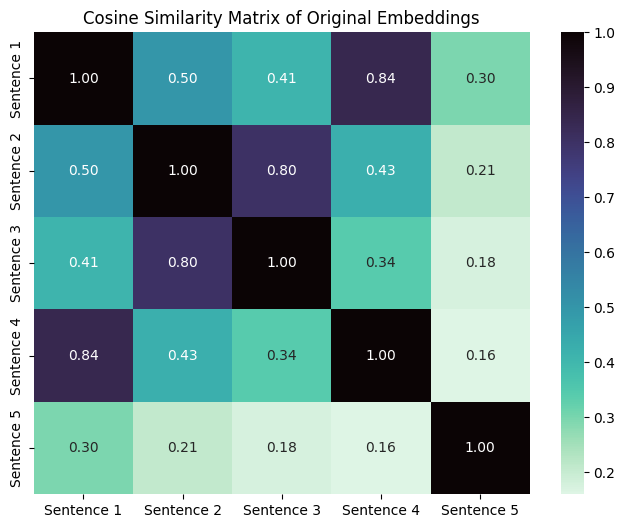

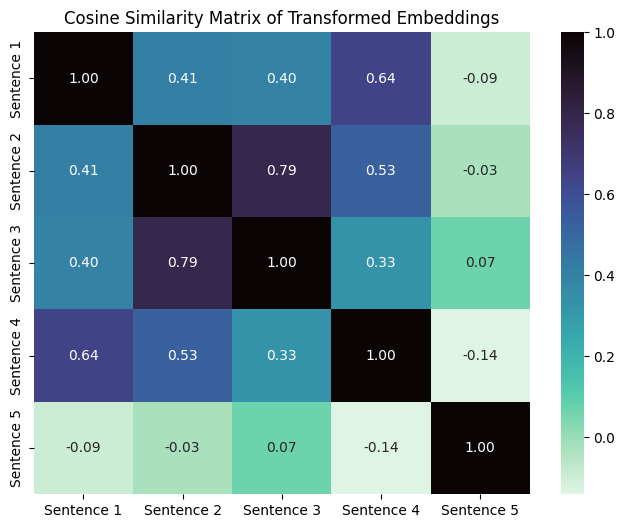

In [16]:
# anchor_ex = "First, let's calculate how many clips Mohammad sold in May. We know that he sold half as many clips in May as he did in April. To find this out, we need to divide the number of clips sold in April by 2. 48 / 2 = 24 So, Mohammad sold 24 clips in May."
# positive_ex = "In May, the number of water bottles sold was quadruple that of April's. With April's sales at 40, May saw 40 * 4 = 160 bottles sold."
# negative_exs = [
#     "Combining April and May's figures gives us a total: 40 bottles from April plus 160 from May equals 200 bottles.",
#     "Therefore, Mohammad sold a total of 72 clips in April and May.",
#     "Step 8: Solve the equation to find the value of x. $15 = $15 + $60 + $7x - $95 $15 = $75 + $7x - $95 $15 = $7x - $20 $35 = $7x x = $35 / $7 x = 5"
# ]

# print(f'ANCHOR   (Sentence 1): ', anchor_ex)
# print(f'POSITIVE (Sentence 2): ', positive_ex)
# for i, negemb in enumerate(negative_exs): 
#     print(f'NEGATIVE (Sentence {i + 3}): ', negemb)

# new_ex_sentences = [anchor_ex] + [positive_ex] + negative_exs
# plot_sim_matrix(new_ex_sentences)

/var/folders/8y/j9pbnmqj2t1bn5kv9ps9lg680000gn/T/ipykernel_3558/664959816.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Sentence {i+1}" for i in range(len(new_sentences))], y=original_first_row, palette="mako_r")


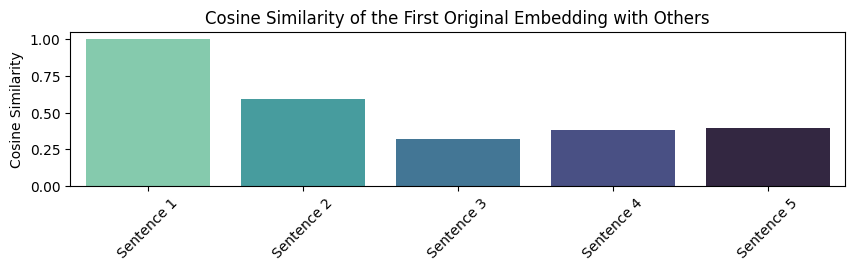

/var/folders/8y/j9pbnmqj2t1bn5kv9ps9lg680000gn/T/ipykernel_3558/664959816.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Sentence {i+1}" for i in range(len(new_sentences))], y=transformed_first_row, palette="mako_r")


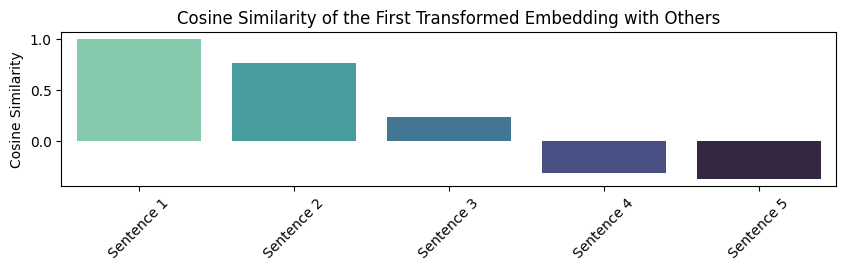

In [25]:
import torch
from sentence_transformers import SentenceTransformer

def plot_first_row_cosine_similarity(new_sentences):
    sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
    original_embeddings = sent_transformer.encode(new_sentences, batch_size=32)
    original_embeddings_tensor = torch.tensor(original_embeddings, dtype=torch.float).to(device)

    # Assuming 'model' and 'device' are defined elsewhere as per the original context
    model.eval()

    with torch.no_grad():
        transformed_embeddings = model(original_embeddings_tensor).cpu().numpy()

    # Compute full cosine similarity matrices
    original_cos_sim_matrix = cosine_similarity(original_embeddings)
    transformed_cos_sim_matrix = cosine_similarity(transformed_embeddings)

    # Extract the first row (cosine similarity of the first embedding with all others)
    original_first_row = original_cos_sim_matrix[0, :]
    transformed_first_row = transformed_cos_sim_matrix[0, :]

    # Plotting the original embeddings' first row cosine similarity
    plt.figure(figsize=(10, 2))
    sns.barplot(x=[f"Sentence {i+1}" for i in range(len(new_sentences))], y=original_first_row, palette="mako_r")
    plt.title('Cosine Similarity of the First Original Embedding with Others')
    plt.ylabel('Cosine Similarity')
    plt.xticks(rotation=45)
    plt.show()

    # Plotting the transformed embeddings' first row cosine similarity
    plt.figure(figsize=(10, 2))
    sns.barplot(x=[f"Sentence {i+1}" for i in range(len(new_sentences))], y=transformed_first_row, palette="mako_r")
    plt.title('Cosine Similarity of the First Transformed Embedding with Others')
    plt.ylabel('Cosine Similarity')
    plt.xticks(rotation=45)
    plt.show()

# Make sure to define or import 'model' and 'device' as they are used in your original code
plot_first_row_cosine_similarity(new_sentences)

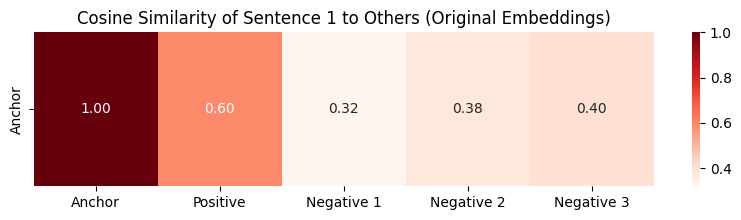

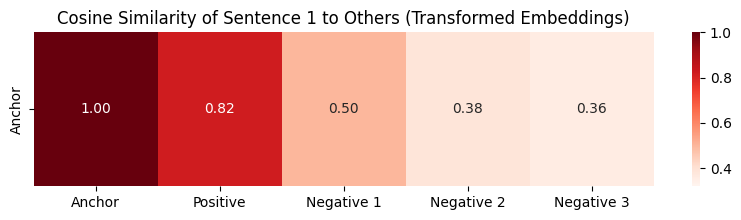

In [325]:
from sentence_transformers import SentenceTransformer
import torch

def plot_sim_matrix(new_sentences):
    sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
    original_embeddings = sent_transformer.encode(new_sentences, batch_size=32)
    original_embeddings_tensor = torch.tensor(original_embeddings, dtype=torch.float).to(device)

    model.eval()

    with torch.no_grad():
        transformed_embeddings = model(original_embeddings_tensor).cpu().numpy()

    # Calculate cosine similarity matrices
    original_cos_sim_matrix = cosine_similarity(original_embeddings)
    transformed_cos_sim_matrix = cosine_similarity(transformed_embeddings)

    first_row_original_cos_sim = original_cos_sim_matrix[0, :].reshape(1, -1)
    first_row_transformed_cos_sim = transformed_cos_sim_matrix[0, :].reshape(1, -1)

    # Find global min and max for consistent color range in heatmaps
    global_min = min(first_row_original_cos_sim.min(), first_row_transformed_cos_sim.min())
    global_max = max(first_row_original_cos_sim.max(), first_row_transformed_cos_sim.max())

    # Plotting the first row of original cosine similarity matrix
    plt.figure(figsize=(10, 2))
    sns.heatmap(first_row_original_cos_sim, annot=True, cmap="Reds", fmt=".2f",
                vmin=global_min, vmax=global_max, # Use global min/max for color scale
                # xticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))],
                # yticklabels=["Sentence 1"])
                xticklabels=["Anchor", "Positive", "Negative 1", "Negative 2", "Negative 3"],
                yticklabels=["Anchor"])
    plt.title('Cosine Similarity of Sentence 1 to Others (Original Embeddings)')
    plt.show()

    # Plotting the first row of transformed cosine similarity matrix
    plt.figure(figsize=(10, 2))
    sns.heatmap(first_row_transformed_cos_sim, annot=True, cmap="Reds", fmt=".2f",
                vmin=global_min, vmax=global_max, # Use global min/max for color scale
                # xticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))],
                # yticklabels=["Sentence 1"])
                xticklabels=["Anchor", "Positive", "Negative 1", "Negative 2", "Negative 3"],
                yticklabels=["Anchor"])
    plt.title('Cosine Similarity of Sentence 1 to Others (Transformed Embeddings)')
    plt.show()

plot_sim_matrix(new_sentences)

ANCHOR   (Sentence 1):  Step 7: We want to find the total cost of the food, which is the sum of the cost of the sandwich, juice, and milk. So we can write the equation Total cost = S + J + M.
POSITIVE (Sentence 2):  Step 7: The total cost is the sum of the bread, napkins, and jam, so Total cost = B + N + J.
NEGATIVE (Sentence 3):  Step 10: We want to find the value of S that makes the equation from step 9 true. So we can solve the equation 7 + 3.5S = Total cost for S.
NEGATIVE (Sentence 4):  Now, let's subtract the discount amount from the total cost of the flowers to find the final cost after the discount: $30.00 - $3.00 = $27.00.
NEGATIVE (Sentence 5):  Next, let's calculate how much Tim paid for his cat's visit. The total cost of the visit was $120 and insurance covered $60, so Tim paid $120 - $60 = $60.


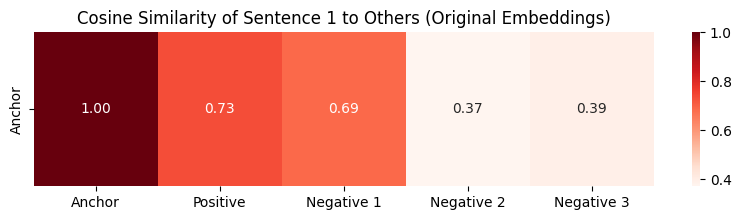

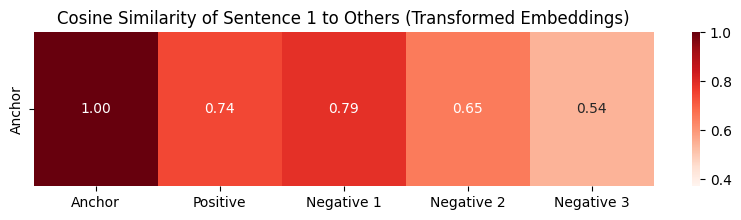

In [354]:
# rand_df = df.loc[df.split == 'val'].sample(1, random_state=33)
rand_df = df.loc[df.split == 'val'].sample(1)

positiveEmb, negativeEmb = rand_df['Positive'].tolist()[0][:3], rand_df['Negative'].tolist()[0][:3]
print(f'ANCHOR   (Sentence 1): ', rand_df['Reasoning Trace'].tolist()[0])
print(f'POSITIVE (Sentence 2): ', positiveEmb[0])
for i, negemb in enumerate(negativeEmb): 
    print(f'NEGATIVE (Sentence {i + 3}): ', negemb)

new_sentences = rand_df['Reasoning Trace'].tolist() + rand_df['Positive'].tolist()[0][:3] + rand_df['Negative'].tolist()[0][:3]
new_sentences

plot_sim_matrix(new_sentences)

ANCHOR   (Sentence 1):  Step 2: Convert the length of the newest movie from hours to minutes. Since there are 60 minutes in an hour, we can calculate the length of the newest movie in minutes by multiplying the length in hours by 60. 3.2 hours * 60 minutes/hour = 192 minutes
POSITIVE (Sentence 2):  Step 2: Convert the bake time of the larger cake from hours to minutes. There are 60 minutes in an hour, so we calculate the bake time of the larger cake in minutes by multiplying the bake time in hours by 60. 3.2 hours * 60 minutes/hour = 192 minutes.
NEGATIVE (Sentence 3):  To convert this back to inches, we multiply by 12: 4.16 feet * 12 inches/foot = 49.92 inches
NEGATIVE (Sentence 4):  Now, let's calculate how much Derek spends on his school supplies. He spends a quarter of what is left, which is $480/4 = $120.
NEGATIVE (Sentence 5):  Now, let's subtract the discount amount from the total cost of the flowers to find the final cost after the discount: $30.00 - $3.00 = $27.00.


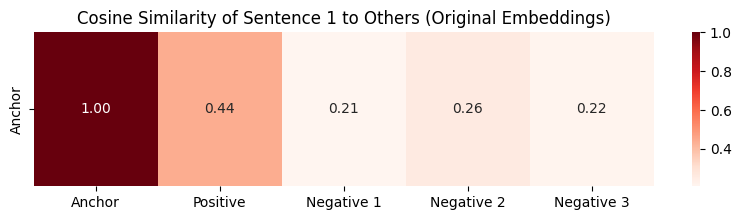

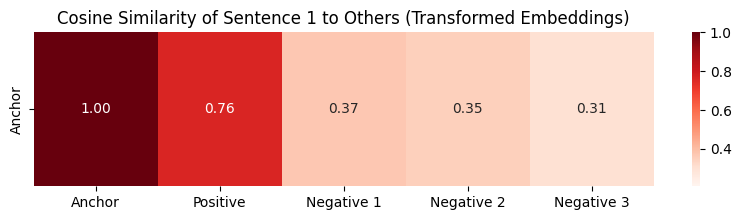

In [326]:
anchor_ex = "Step 2: Convert the length of the newest movie from hours to minutes. Since there are 60 minutes in an hour, we can calculate the length of the newest movie in minutes by multiplying the length in hours by 60. 3.2 hours * 60 minutes/hour = 192 minutes"
positive_ex = "Step 2: Convert the bake time of the larger cake from hours to minutes. There are 60 minutes in an hour, so we calculate the bake time of the larger cake in minutes by multiplying the bake time in hours by 60. 3.2 hours * 60 minutes/hour = 192 minutes."
negative_exs = [
    "To convert this back to inches, we multiply by 12: 4.16 feet * 12 inches/foot = 49.92 inches",
    "Now, let's calculate how much Derek spends on his school supplies. He spends a quarter of what is left, which is $480/4 = $120.",
    "Now, let's subtract the discount amount from the total cost of the flowers to find the final cost after the discount: $30.00 - $3.00 = $27.00."
]

print(f'ANCHOR   (Sentence 1): ', anchor_ex)
print(f'POSITIVE (Sentence 2): ', positive_ex)
for i, negemb in enumerate(negative_exs): 
    print(f'NEGATIVE (Sentence {i + 3}): ', negemb)

new_ex_sentences = [anchor_ex] + [positive_ex] + negative_exs
plot_sim_matrix(new_ex_sentences)

InfoNCE Loss

In [1]:
from info_nce import InfoNCE, info_nce

In [ ]:
loss = InfoNCE()
batch_size, embedding_size = 32, 128
query = torch.randn(batch_size, embedding_size)
positive_key = torch.randn(batch_size, embedding_size)
output = loss(query, positive_key)

Adjacent Trace Similarity

In [73]:
df.head()

,Problem Number,Question,Answer,split,Paraphrased Question,Reasoning Trace,Positive,Negative,Final Score
0,0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,train,Derek collected seashells from 48 of his frien...,"First, let's find out how many clips Natalia s...","['First, we need to figure out the number of s...","[""Since we can't have a fraction of a customer...",1
1,0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,train,Derek collected seashells from 48 of his frien...,To find out how many clips Natalia sold altoge...,['To determine the total number of seashells D...,"[""Therefore, Benedict's house is 2350 square f...",1
2,0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,train,Derek collected seashells from 48 of his frien...,"Therefore, Natalia sold a total of 72 clips in...","['In conclusion, Derek collected a combined su...","['Therefore, the unicorn piñata and the treats...",1
3,1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,train,Liam makes $12 per hour tutoring. He tutored f...,"To find out how much Weng earned, we need to c...","[""First, we need to figure out Liam's earnings...",['To find out how much more the cow is worth a...,1
4,1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,train,Liam makes $12 per hour tutoring. He tutored f...,"Now, we can multiply the minute rate by the nu...","[""Next, we calculate Liam's total earnings by ...",['Step 2: She spent a seventh of it on a milks...,1


In [75]:
import ast
df = pd.read_csv("data/gsm8k_cl_trans_para1_112_autosplit_autograded.csv")
df['Positive'] = df['Positive'].apply(ast.literal_eval)
df['Negative'] = df['Negative'].apply(ast.literal_eval)

In [60]:
df['Final Score'].value_counts()

Final Score
1    346
0    152
Name: count, dtype: int64

In [107]:
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance

def plot_cot_step_metrics(cot_collection, paraphrased_cot_collection, sent_transformer):
    """
    Plots metric sequence for all inputted sentences
    """
    embeddings_collection = []
    paraphrased_embeddings_collection = []
    metrics_adjacent_collection = []
    metrics_random_collection = []

    paraphrased_metrics_adjacent_collection = [] 
    
    for trace, paraphrased_trace in zip(cot_collection, paraphrased_cot_collection):
    # for trace in cot_collection:
        embeddings = [sent_transformer.encode(step) for step in trace] 
        embeddings_collection.append(embeddings)
        metrics_adjacent = []
        metrics_random = []
        
        paraphrased_embeddings = [sent_transformer.encode(step) for step in paraphrased_trace]
        paraphrased_embeddings_collection.append(paraphrased_embeddings)
        para_metrics_adjacent = []
        
        for i in range(len(embeddings) - 1):
            emb1 = embeddings[i]
            emb2 = embeddings[i + 1]

            # Compute metric for adjacent steps
            metric_adjacent = distance.euclidean(emb1, emb2)
            metrics_adjacent.append(metric_adjacent)

            # Compute metric for random steps
            other_embeddings = embeddings[:i] + embeddings[i+2:]  # Exclude the current and next step's embeddings
            emb_random = random.choice(other_embeddings)
            metric_random = distance.euclidean(emb1, emb_random)
            metrics_random.append(metric_random)

            
            para_emb1 = paraphrased_embeddings[i]
            para_emb2 = paraphrased_embeddings[i + 1]

            # Compute metric for adjacent steps for paraphrased embeddings
            para_metric_adjacent = distance.euclidean(para_emb1, para_emb2)
            para_metrics_adjacent.append(para_metric_adjacent)

        metrics_adjacent_collection.append(metrics_adjacent)
        metrics_random_collection.append(metrics_random)

    # Plotting
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors for the traces
    max_len = max(len(metrics) for metrics in metrics_adjacent_collection)  # Find the longest sequence
    x_ticks_labels = [f'({i}, {i+1})' for i in range(max_len)]  # Generate custom labels for x-axis
    for i, (metrics_adjacent, metrics_adjacent_paraphrased) in enumerate(zip(metrics_adjacent_collection, paraphrased_metrics_adjacent_collection)):
        indices = list(range(len(metrics_adjacent)))
        color = colors[i % len(colors)]  # Select a color from the list
        plt.plot(indices, metrics_adjacent, label=f'Trace {i+1} (Original)', color=color)
        plt.plot(indices, metrics_adjacent_paraphrased, label=f'Trace {i+1} (Paraphrased)', linestyle='dashed', color=color)
        # plt.plot(indices, metrics_random, label=f'Trace {i+1} (Random)', linestyle='dashed', color=color)

    plt.xlabel('Step Index')
    plt.ylabel('Euclidean Distance')
    plt.title('Euclidean Distance between Original and Paraphrased Embeddings for Each Trace')
    plt.xticks(range(max_len), x_ticks_labels)  # Apply custom x-axis labels
    plt.legend()
    plt.show()

In [166]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def plot_pairwise_cosine_similarities_raw(cot_collection, paraphrased_cot_collection, sent_transformer, prob_nos):
    """
    Plots pairwise cosine similarities for sequences of text in cot_collection and paraphrased_cot_collection
    using line plots, all in the same figure.
    
    Parameters:
    - cot_collection: List of lists of strings. Each inner list is a sequence of text.
    - paraphrased_cot_collection: List of lists of strings, corresponding to cot_collection.
    - sent_transformer: Sentence transformer model for encoding texts into embeddings.
    """
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for the plots
    
    plt.figure(figsize=(10, 6))  # Initialize the figure outside the loop
    
    for idx, (original_seq, paraphrased_seq) in enumerate(zip(cot_collection, paraphrased_cot_collection)):
        color = colors[idx % len(colors)]  # Cycle through colors
        
        # Convert sequences of text to sequences of embeddings
        original_embeddings = sent_transformer.encode(original_seq, convert_to_tensor=False)
        paraphrased_embeddings = sent_transformer.encode(paraphrased_seq, convert_to_tensor=False)
        
        # Calculate pairwise cosine similarities for consecutive embeddings
        original_cos_sims = [cosine_similarity([original_embeddings[i]], [original_embeddings[i+1]])[0][0] for i in range(len(original_seq)-1)]
        paraphrased_cos_sims = [cosine_similarity([paraphrased_embeddings[i]], [paraphrased_embeddings[i+1]])[0][0] for i in range(len(paraphrased_seq)-1)]
        
        x_indices = np.arange(len(original_seq)-1)
        
        # Plot the original and paraphrased cosine similarities
        plt.plot(x_indices, original_cos_sims, marker='o', linestyle='-', label=f'Original {prob_nos[idx]}', color=color)
        plt.plot(x_indices, paraphrased_cos_sims, marker='s', linestyle='--', label=f'Paraphrased {prob_nos[idx]}', color=color)
    
    plt.xlabel('Embedding Pairs')
    plt.ylabel('Cosine Similarity')
    plt.title('Pairwise Cosine Similarities Across Sequences for Different Problems using Raw Embeddings')
    plt.xticks(x_indices, [f'{i+1}-{i+2}' for i in range(len(original_seq)-1)])
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_pairwise_cosine_similarities_line(cot_collection, paraphrased_cot_collection, sent_transformer)

In [167]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def plot_pairwise_cosine_similarities_transformed(cot_collection, paraphrased_cot_collection, sent_transformer, model, prob_nos):
    """
    Plots pairwise cosine similarities for sequences of text in cot_collection and paraphrased_cot_collection
    using line plots, all in the same figure.
    
    Parameters:
    - cot_collection: List of lists of strings. Each inner list is a sequence of text.
    - paraphrased_cot_collection: List of lists of strings, corresponding to cot_collection.
    - sent_transformer: Sentence transformer model for encoding texts into embeddings.
    """
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for the plots
    
    plt.figure(figsize=(10, 6))  # Initialize the figure outside the loop
    
    for idx, (original_seq, paraphrased_seq) in enumerate(zip(cot_collection, paraphrased_cot_collection)):
        color = colors[idx % len(colors)]  # Cycle through colors
        
        # Convert sequences of text to sequences of embeddings
        original_embeddings = sent_transformer.encode(original_seq, convert_to_tensor=True)
        paraphrased_embeddings = sent_transformer.encode(paraphrased_seq, convert_to_tensor=True)

        model.eval()

        with torch.no_grad():
            original_embeddings_transformed = model(original_embeddings).cpu().numpy()
            paraphrased_embeddings_transformed = model(paraphrased_embeddings).cpu().numpy()
        
        # Calculate pairwise cosine similarities for consecutive embeddings
        original_cos_sims = [cosine_similarity([original_embeddings_transformed[i]], [original_embeddings_transformed[i+1]])[0][0] for i in range(len(original_seq)-1)]
        paraphrased_cos_sims = [cosine_similarity([paraphrased_embeddings_transformed[i]], [paraphrased_embeddings_transformed[i+1]])[0][0] for i in range(len(paraphrased_seq)-1)]
        
        x_indices = np.arange(len(original_seq)-1)
        
        # Plot the original and paraphrased cosine similarities
        plt.plot(x_indices, original_cos_sims, marker='o', linestyle='-', label=f'Original {prob_nos[idx]}', color=color)
        plt.plot(x_indices, paraphrased_cos_sims, marker='s', linestyle='--', label=f'Paraphrased {prob_nos[idx]}', color=color)
    
    plt.xlabel('Embedding Pairs')
    plt.ylabel('Cosine Similarity')
    plt.title('Pairwise Cosine Similarities Across Sequences for Different Problems using Transformed Embeddings')
    plt.xticks(x_indices, [f'{i+1}-{i+2}' for i in range(len(original_seq)-1)])
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_pairwise_cosine_similarities_line(cot_collection, paraphrased_cot_collection, sent_transformer)

In [173]:
(df.loc[df['Problem Number'] == 45]['Question'].tolist()[0])

'James spends 40 years teaching.  His partner has been teaching for 10 years less.  How long is their combined experience?'

In [185]:
prob_nos = set()
while len(prob_nos) < 2:
    prob_nos.add(random.randint(0, 112))
prob_nos = list(prob_nos)
print("Problem Numbers: ", prob_nos)
cot_collection = []
paraphrased_cot_collection = []
for prob_no in prob_nos:
    print("PROBLEM NUMBER: ", prob_no)
    reasoning_trace_list = (df.loc[df['Problem Number'] == prob_no])['Reasoning Trace'].tolist()
    paraphrased_reasoning_trace_list = (df.loc[df['Problem Number'] == prob_no])['Positive'].tolist()
    paraphrased_reasoning_trace_list = [step[0] for step in paraphrased_reasoning_trace_list]
    for i, steps in enumerate(zip(reasoning_trace_list, paraphrased_reasoning_trace_list)):
        print(i, steps[0])
        print(i, steps[1])
    cot_collection.append(reasoning_trace_list)
    paraphrased_cot_collection.append(paraphrased_reasoning_trace_list)
    print()
sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')

Problem Numbers:  [42, 102]
PROBLEM NUMBER:  42
0 Step 1: Calculate the total amount of money Hillary made from selling crafts. Hillary sold 3 crafts for $12 each, so she made 3 * $12 = $<<3*12=36>>36 from selling crafts.
0 Step 1: Determine the total revenue Derek earned from selling bookmarks. Derek sold 3 bookmarks at $12 apiece, which means he earned 3 * $12 = $36 from bookmark sales.
1 Step 2: Add the extra money Hillary received from the appreciative customer. Hillary received an extra $7, so her total earnings are now $36 + $7 = $<<36+7=43>>43.
1 Step 2: Include the extra amount given by the generous parent. Derek was given an additional $7, bringing his total to $36 + $7 = $43.
2 Step 3: Subtract the amount Hillary deposited into her bank account. Hillary deposited $18 into her bank account, so she is left with $43 - $18 = $<<43-18=25>>25.
2 Step 3: Calculate the remaining amount after Derek saves a portion. Derek saves $18, so he has $43 - $18 = $25 left.
3 Therefore, Hillary 

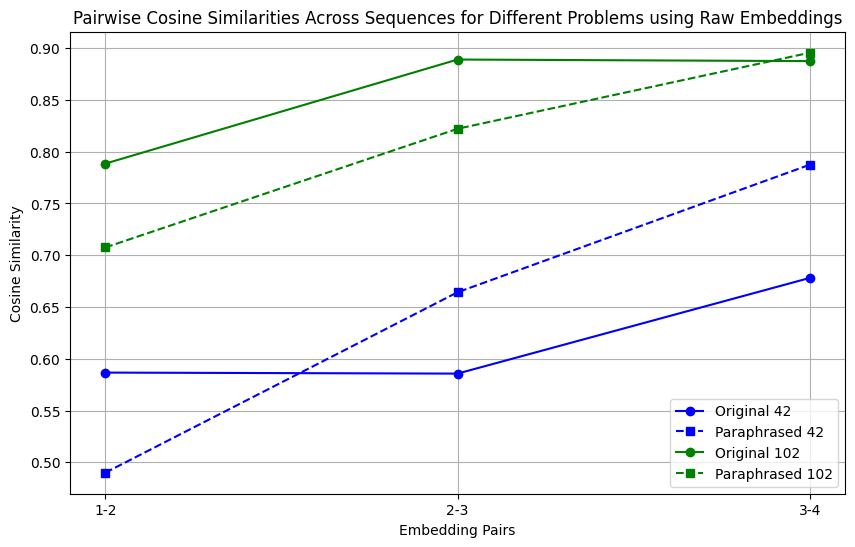

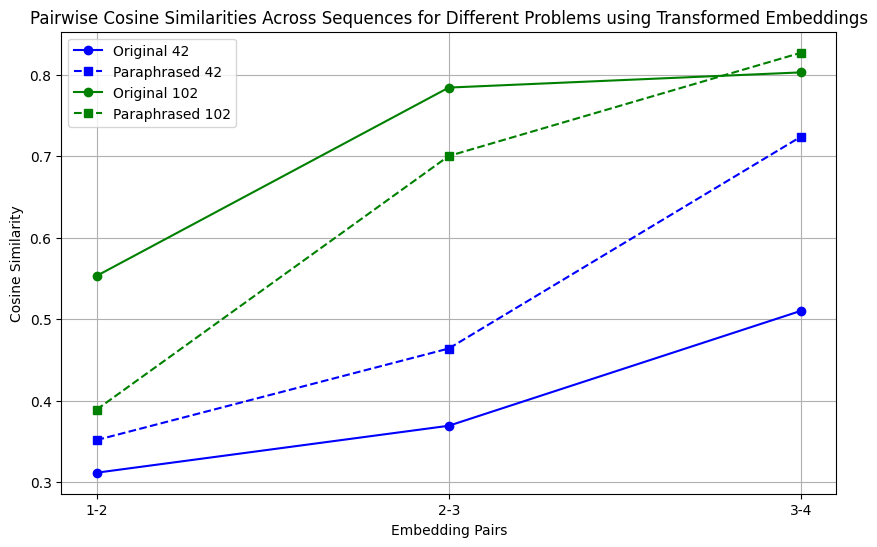

In [186]:
plot_pairwise_cosine_similarities_raw(cot_collection, paraphrased_cot_collection, sent_transformer, prob_nos)
plot_pairwise_cosine_similarities_transformed(cot_collection, paraphrased_cot_collection, sent_transformer, model, prob_nos)

Generic Metric

In [253]:
def sequence_diffs(orig, para):
    diffs = []
    for emb1, emb2 in zip(orig, para):
        diffs.append(emb1 - emb2)
    return diffs

In [327]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def plot_pairwise_metrics_raw(metric_name, cot_collection, paraphrased_cot_collection, sent_transformer, prob_nos):
    """
    Plots pairwise metrics for sequences of text in cot_collection and paraphrased_cot_collection
    using line plots, all in the same figure.
    
    Parameters:
    - cot_collection: List of lists of strings. Each inner list is a sequence of text.
    - paraphrased_cot_collection: List of lists of strings, corresponding to cot_collection.
    - sent_transformer: Sentence transformer model for encoding texts into embeddings.
    """
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for the plots

    
    plt.figure(figsize=(10, 6))  # Initialize the figure outside the loop
    
    for idx, (original_seq, paraphrased_seq) in enumerate(zip(cot_collection, paraphrased_cot_collection)):
        color = colors[idx % len(colors)]  # Cycle through colors
        
        # Convert sequences of text to sequences of embeddings
        original_embeddings = sent_transformer.encode(original_seq, convert_to_tensor=False)
        paraphrased_embeddings = sent_transformer.encode(paraphrased_seq, convert_to_tensor=False)
        
        # Calculate pairwise metrics for consecutive embeddings
        metric_to_function = {'Cosine Similarity' : cosine_similarity, 'Euclidean Distance' : euclidean_distances}
        metric_function = metric_to_function[metric_name]
        original_cos_sims = [metric_function([original_embeddings[i]], [original_embeddings[i+1]])[0][0] for i in range(len(original_seq)-1)]
        paraphrased_cos_sims = [metric_function([paraphrased_embeddings[i]], [paraphrased_embeddings[i+1]])[0][0] for i in range(len(paraphrased_seq)-1)]
        
        x_indices = np.arange(len(original_seq)-1)
        
        # Plot the original and paraphrased metrics
        plt.plot(x_indices, original_cos_sims, marker='o', linestyle='-', label=f'Original {prob_nos[idx]}', color=color)
        plt.plot(x_indices, paraphrased_cos_sims, marker='s', linestyle='--', label=f'Paraphrased {prob_nos[idx]}', color=color)
    
    plt.xlabel('Embedding Pairs')
    plt.ylabel(metric_name)
    plt.title(f'Pairwise {metric_name} Across Sequences for Different Problems using Raw Embeddings')
    plt.xticks(x_indices, [f'{i+1}-{i+2}' for i in range(len(original_seq)-1)])
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pairwise_metrics_transformed(metric_name, cot_collection, paraphrased_cot_collection, sent_transformer, model, prob_nos):
    """
    Plots pairwise metrics for sequences of text in cot_collection and paraphrased_cot_collection
    using line plots, all in the same figure.
    
    Parameters:
    - cot_collection: List of lists of strings. Each inner list is a sequence of text.
    - paraphrased_cot_collection: List of lists of strings, corresponding to cot_collection.
    - sent_transformer: Sentence transformer model for encoding texts into embeddings.
    """
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for the plots
    # max_seq_length = max([len(seq) for seq in cot_collection])
    
    plt.figure(figsize=(10, 6))  # Initialize the figure outside the loop
    
    for idx, (original_seq, paraphrased_seq) in enumerate(zip(cot_collection, paraphrased_cot_collection)):
        color = colors[idx % len(colors)]  # Cycle through colors
        
        # Convert sequences of text to sequences of embeddings
        original_embeddings = sent_transformer.encode(original_seq, convert_to_tensor=True)
        paraphrased_embeddings = sent_transformer.encode(paraphrased_seq, convert_to_tensor=True)

        model.eval()

        with torch.no_grad():
            original_embeddings_transformed = model(original_embeddings).cpu().numpy()
            paraphrased_embeddings_transformed = model(paraphrased_embeddings).cpu().numpy()
        
        # Calculate pairwise metrics for consecutive embeddings
        metric_to_function = {'Cosine Similarity' : cosine_similarity, 'Euclidean Distance' : euclidean_distances}
        metric_function = metric_to_function[metric_name]
        
        original_cos_sims = [metric_function([original_embeddings_transformed[i]], [original_embeddings_transformed[i+1]])[0][0] for i in range(len(original_seq)-1)]
        paraphrased_cos_sims = [metric_function([paraphrased_embeddings_transformed[i]], [paraphrased_embeddings_transformed[i+1]])[0][0] for i in range(len(paraphrased_seq)-1)]
        
        x_indices = np.arange(len(original_seq)-1)
        
        # Plot the original and paraphrased metrics
        plt.plot(x_indices, original_cos_sims, marker='o', linestyle='-', label=f'Original {prob_nos[idx]}', color=color)
        plt.plot(x_indices, paraphrased_cos_sims, marker='s', linestyle='--', label=f'Paraphrased {prob_nos[idx]}', color=color)
    
    plt.xlabel('Embedding Pairs')
    plt.ylabel(metric_name)
    plt.title(f'Pairwise {metric_name} Across Sequences for Different Problems using Transformed Embeddings')
    plt.xticks(x_indices, [f'{i+1}-{i+2}' for i in range(len(original_seq)-1)])
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pairwise_metrics_raw_and_transformed(metric_name, cot_collection, paraphrased_cot_collection, sent_transformer, model, prob_nos):
    """
    Plots pairwise metrics for sequences of text in cot_collection and paraphrased_cot_collection
    using line plots, all in the same figure.
    
    Parameters:
    - cot_collection: List of lists of strings. Each inner list is a sequence of text.
    - paraphrased_cot_collection: List of lists of strings, corresponding to cot_collection.
    - sent_transformer: Sentence transformer model for encoding texts into embeddings.
    """
    colors = ['royalblue', 'royalblue', 'b', 'g', 'r', 'c', 'm', 'y', 'k']
    trans_colors = ['mediumseagreen', 'darkorchid', 'orange', 'm', 'c', 'r', 'g', 'b', 'lime']
    
    plt.figure(figsize=(10, 6))
        
    res_raw = []
    res_trans = []

    for idx, (original_seq, paraphrased_seq) in enumerate(zip(cot_collection, paraphrased_cot_collection)):
        color = colors[idx % len(colors)]
        trans_color = trans_colors[idx % len(trans_colors)]
        
        # Convert sequences of text to sequences of embeddings
        original_embeddings = sent_transformer.encode(original_seq, convert_to_tensor=True)
        paraphrased_embeddings = sent_transformer.encode(paraphrased_seq, convert_to_tensor=True)

        model.eval()

        with torch.no_grad():
            original_embeddings_transformed = model(original_embeddings).cpu().numpy()
            paraphrased_embeddings_transformed = model(paraphrased_embeddings).cpu().numpy()

        original_embeddings = original_embeddings.cpu().numpy()
        paraphrased_embeddings = paraphrased_embeddings.cpu().numpy() 

        # Calculate pairwise metrics for consecutive embeddings
        metric_to_function = {'Cosine Similarity' : cosine_similarity, 'Euclidean Distance' : euclidean_distances}
        metric_function = metric_to_function[metric_name]
        
        original_cos_sims = [metric_function([original_embeddings[i]], [original_embeddings[i+1]])[0][0] for i in range(len(original_seq)-1)]
        paraphrased_cos_sims = [metric_function([paraphrased_embeddings[i]], [paraphrased_embeddings[i+1]])[0][0] for i in range(len(paraphrased_seq)-1)]
        
        res_raw.append(sequence_diffs(original_cos_sims, paraphrased_cos_sims))

        original_cos_sims_trans = [metric_function([original_embeddings_transformed[i]], [original_embeddings_transformed[i+1]])[0][0] for i in range(len(original_seq)-1)]
        paraphrased_cos_sims_trans = [metric_function([paraphrased_embeddings_transformed[i]], [paraphrased_embeddings_transformed[i+1]])[0][0] for i in range(len(paraphrased_seq)-1)]
        
        res_trans.append(sequence_diffs(original_cos_sims_trans, paraphrased_cos_sims_trans))

        x_indices = np.arange(len(original_seq)-1)
        plt.plot(x_indices, original_cos_sims, marker='o', linestyle='-', label=f'Original Problem {prob_nos[idx]} (Raw)', color=color)
        plt.plot(x_indices, paraphrased_cos_sims, marker='s', linestyle='--', label=f'Paraphrased Problem {prob_nos[idx]} (Raw)', color=color)
        plt.plot(x_indices, original_cos_sims_trans, marker='o', linestyle='-', label=f'Original Problem {prob_nos[idx]} (Transformed)', color=trans_color)
        plt.plot(x_indices, paraphrased_cos_sims_trans, marker='s', linestyle='--', label=f'Paraphrased Problem {prob_nos[idx]} (Transformed)', color=trans_color)
    
    plt.xlabel('Embedding Pairs')
    plt.ylabel(metric_name)
    plt.title(f'Pairwise {metric_name} Across Reasoning Sequences using Raw vs. Transformed Embeddings')
    plt.xticks(x_indices, [f'{i+1}-{i+2}' for i in range(len(original_seq)-1)])
    plt.legend()
    plt.grid(True)
    plt.show()

    return res_raw, res_trans


In [328]:
prob_nos = set()
while len(prob_nos) < 1:
    prob_nos.add(random.randint(0, 112))
prob_nos = list(prob_nos)
print("Problem Numbers: ", prob_nos)
cot_collection = []
paraphrased_cot_collection = []
for prob_no in prob_nos:
    print("PROBLEM NUMBER: ", prob_no)
    reasoning_trace_list = (df.loc[df['Problem Number'] == prob_no])['Reasoning Trace'].tolist()
    paraphrased_reasoning_trace_list = (df.loc[df['Problem Number'] == prob_no])['Positive'].tolist()
    paraphrased_reasoning_trace_list = [step[0] for step in paraphrased_reasoning_trace_list]
    for i, steps in enumerate(zip(reasoning_trace_list, paraphrased_reasoning_trace_list)):
        print(i, steps[0])
        print(i, steps[1])
    cot_collection.append(reasoning_trace_list)
    paraphrased_cot_collection.append(paraphrased_reasoning_trace_list)
    print()
sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')

Problem Numbers:  [81]
PROBLEM NUMBER:  81
0 First, let's assume the number of large animals is x.
0 First, we assume the quantity of large lanterns Charlie made is x.
1 Since small animals are three times as many as large animals, the number of small animals is 3x.
1 Given that the small lanterns are three times the number of large lanterns, the quantity of small lanterns is 3x.
2 The total number of sticks of wax used for small animals is 12, so each small animal takes 12/3x = 4 sticks of wax.
2 Charlie used 12 sheets of paper for the small lanterns, which means each small lantern requires 12/3x = 4 sheets of paper.
3 The total number of sticks of wax used for large animals is 4x.
3 The total sheets of paper used for large lanterns is 4x since each large lantern requires four sheets.
4 Therefore, the total number of sticks of wax used for all animals is 4x + 4(3x) = 4x + 12x = 16x.
4 To find the total sheets of paper used for all lanterns, we add the sheets used for large and small l

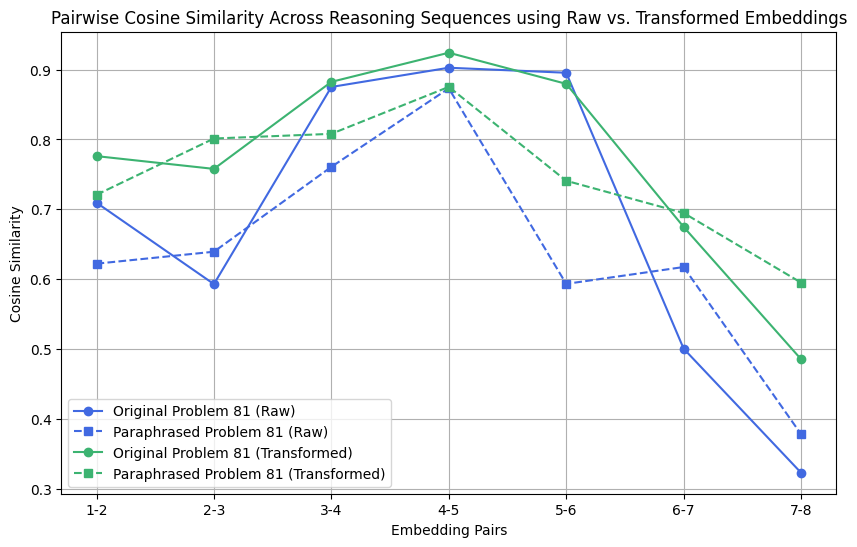

In [329]:
# plot_pairwise_metrics_raw('Euclidean Distance', cot_collection, paraphrased_cot_collection, sent_transformer, prob_nos)
# plot_pairwise_metrics_transformed('Euclidean Distance', cot_collection, paraphrased_cot_collection, sent_transformer, model, prob_nos)
# plot_pairwise_metrics_raw('Cosine Similarity', cot_collection, paraphrased_cot_collection, sent_transformer, prob_nos)
# plot_pairwise_metrics_transformed('Cosine Similarity', cot_collection, paraphrased_cot_collection, sent_transformer, model, prob_nos)
res_raw, res_trans = plot_pairwise_metrics_raw_and_transformed('Cosine Similarity', cot_collection, paraphrased_cot_collection, sent_transformer, model, prob_nos)

In [330]:
df

,Problem Number,Question,Answer,split,Paraphrased Question,Reasoning Trace,Positive,Negative,Final Score
0,0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,train,Derek collected seashells from 48 of his frien...,"First, let's find out how many clips Natalia s...","[First, we need to figure out the number of se...","[Since we can't have a fraction of a customer,...",1
1,0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,train,Derek collected seashells from 48 of his frien...,To find out how many clips Natalia sold altoge...,[To determine the total number of seashells De...,"[Therefore, Benedict's house is 2350 square fe...",1
2,0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,train,Derek collected seashells from 48 of his frien...,"Therefore, Natalia sold a total of 72 clips in...","[In conclusion, Derek collected a combined sum...","[Therefore, the unicorn piñata and the treats ...",1
3,1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,train,Liam makes $12 per hour tutoring. He tutored f...,"To find out how much Weng earned, we need to c...","[First, we need to figure out Liam's earnings ...",[To find out how much more the cow is worth af...,1
4,1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,train,Liam makes $12 per hour tutoring. He tutored f...,"Now, we can multiply the minute rate by the nu...","[Next, we calculate Liam's total earnings by m...",[Step 2: She spent a seventh of it on a milksh...,1
...,...,...,...,...,...,...,...,...,...
493,111,Christina has 3 snakes. 1 snake is 2 feet long...,The first snake is 24 inches because there are...,val,Oliver has 3 ropes. 1 rope is 2 feet long. Ano...,"Therefore, all of Christina's snakes combined ...","[Thus, the combined length of all Oliver's rop...","[First, let's calculate the total number of gl...",0
494,112,Madeline has 5 boxes with 24 crayons in each. ...,Two boxes of crayons have 24 x 5/8 = <<24*5/8=...,val,Oliver has 5 baskets with 24 apples in each. H...,Step 1: Calculate the total number of crayons ...,[Step 1: Determine the total number of fresh a...,"[Step 3: On Wednesday, Buddy buys 12 baseball ...",0
495,112,Madeline has 5 boxes with 24 crayons in each. ...,Two boxes of crayons have 24 x 5/8 = <<24*5/8=...,val,Oliver has 5 baskets with 24 apples in each. H...,Step 2: Calculate the total number of crayons ...,[Step 2: Figure out the total number of fresh ...,"[Finally, let's calculate the total amount of ...",0
496,112,Madeline has 5 boxes with 24 crayons in each. ...,Two boxes of crayons have 24 x 5/8 = <<24*5/8=...,val,Oliver has 5 baskets with 24 apples in each. H...,Step 3: Calculate the number of unused crayons...,[Step 3: Assess the number of fresh apples in ...,"[First, let's calculate the total cost of the ...",0


In [331]:
def calculate_metric_diff_across_sequence_raw_vs_trans(metric_name, sent_transformer, model, df):
    cot_collection = []
    paraphrased_cot_collection = []
    
    for prob_no in range(df['Problem Number'].max() + 1):
        reasoning_trace_list = (df.loc[df['Problem Number'] == prob_no])['Reasoning Trace'].tolist()
        paraphrased_reasoning_trace_list = (df.loc[df['Problem Number'] == prob_no])['Positive'].tolist()
        paraphrased_reasoning_trace_list = [step[0] for step in paraphrased_reasoning_trace_list]
        cot_collection.append(reasoning_trace_list)
        paraphrased_cot_collection.append(paraphrased_reasoning_trace_list)    
    
    res_raw = {}
    res_trans = {}

    for idx, (original_seq, paraphrased_seq) in enumerate(zip(cot_collection, paraphrased_cot_collection)):
        original_embeddings = sent_transformer.encode(original_seq, convert_to_tensor=True)
        paraphrased_embeddings = sent_transformer.encode(paraphrased_seq, convert_to_tensor=True)

        model.eval()

        with torch.no_grad():
            original_embeddings_transformed = model(original_embeddings).cpu().numpy()
            paraphrased_embeddings_transformed = model(paraphrased_embeddings).cpu().numpy()

        original_embeddings = original_embeddings.cpu().numpy()
        paraphrased_embeddings = paraphrased_embeddings.cpu().numpy() 

        # Calculate pairwise metrics for consecutive embeddings
        metric_to_function = {'Cosine Similarity' : cosine_similarity, 'Euclidean Distance' : euclidean_distances}
        metric_function = metric_to_function[metric_name]
        
        original_cos_sims = [metric_function([original_embeddings[i]], [original_embeddings[i+1]])[0][0] for i in range(len(original_seq)-1)]
        paraphrased_cos_sims = [metric_function([paraphrased_embeddings[i]], [paraphrased_embeddings[i+1]])[0][0] for i in range(len(paraphrased_seq)-1)]
        
        original_cos_sims_trans = [metric_function([original_embeddings_transformed[i]], [original_embeddings_transformed[i+1]])[0][0] for i in range(len(original_seq)-1)]
        paraphrased_cos_sims_trans = [metric_function([paraphrased_embeddings_transformed[i]], [paraphrased_embeddings_transformed[i+1]])[0][0] for i in range(len(paraphrased_seq)-1)]

        raw_diffs = sequence_diffs(original_cos_sims, paraphrased_cos_sims)
        trans_diffs = sequence_diffs(original_cos_sims_trans, paraphrased_cos_sims_trans)

        res_raw[idx] = raw_diffs
        res_trans[idx] = trans_diffs
    
    return res_raw, res_trans

In [332]:
res_raw, res_trans = calculate_metric_diff_across_sequence_raw_vs_trans("Cosine Similarity", sent_transformer, model, df)

In [333]:
problem_df = pd.read_csv('data/113_gsm8k_gpt35_cot_responses_autograded.csv')

In [334]:
problem_df

,Problem Number,Question,Answer,CoT Response,CoT Sentences,CoT Steps,split,Paraphrased Question,Paraphrased CoT Steps,True Answer,Final Score
0,0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,"First, let's find out how many clips Natalia s...","**\nFirst, let's find out how many clips Natal...","[""First, let's find out how many clips Natalia...",train,Derek collected seashells from 48 of his frien...,"['First, we need to figure out the number of s...",72,1
1,1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,"To find out how much Weng earned, we need to c...","**\nTo find out how much Weng earned, we need ...","['To find out how much Weng earned, we need to...",train,Liam makes $12 per hour tutoring. He tutored f...,"[""First, we need to figure out Liam's earnings...",10,1
2,2,Betty is saving money for a new wallet which c...,"In the beginning, Betty has only 100 / 2 = $<<...","First, let's calculate how much money Betty ha...","**\nFirst, let's calculate how much money Bett...","[""First, let's calculate how much money Betty ...",train,Oliver is collecting stickers for his album wh...,"['First, we need to figure out how many sticke...",5,1
3,3,"Julie is reading a 120-page book. Yesterday, s...",Maila read 12 x 2 = <<12*2=24>>24 pages today....,"First, let's find out how many pages Julie has...","**\nFirst, let's find out how many pages Julie...","[""First, let's find out how many pages Julie h...",train,Carlos is painting a fence that has 120 panels...,"['First, we need to calculate the number of pa...",42,1
4,4,James writes a 3-page letter to 2 different fr...,He writes each friend 3*2=<<3*2=6>>6 pages a w...,"First, let's calculate how many letters James ...","**\nFirst, let's calculate how many letters Ja...","[""First, let's calculate how many letters Jame...",train,Olivia plants 3 flowers in each of 2 different...,"['First, we need to figure out how many times ...",624,1
...,...,...,...,...,...,...,...,...,...,...,...
108,108,Simon wanted to buy flowers that his mom could...,5 pansies at $2.50 each is 5*2.50 = $<<5*2.5=1...,"First, let's calculate the total cost of the f...","**\nFirst, let's calculate the total cost of t...","[""First, let's calculate the total cost of the...",val,Oliver decided to purchase books for his siste...,"['First, we need to figure out the total price...",23,1
109,109,Derek has $960 to buy his books for the semest...,Amount spent on textbooks is 960/2 = <<960/2=4...,"First, let's calculate how much Derek spends o...","**\nFirst, let's calculate how much Derek spen...","[""First, let's calculate how much Derek spends...",val,Ava has $960 to spend on her office renovation...,"['First, we need to figure out how much Ava sp...",360,1
110,110,Caleb and his dad went fishing at the lake. C...,Caleb’s dad caught 2 x 3 = <<2*3=6>>6 trouts.\...,Step 1: Caleb caught 2 trouts.\nStep 2: Caleb'...,**\nStep 1: Caleb caught 2 trouts.\n\n||\nStep...,"['Step 1: Caleb caught 2 trouts.', ""Step 2: Ca...",val,Ava and her grandmother went apple picking at ...,"['Step 1: Ava picked 2 baskets of apples.', ""S...",4,1
111,111,Christina has 3 snakes. 1 snake is 2 feet long...,The first snake is 24 inches because there are...,"First, let's convert the measurements to the s...","**\nFirst, let's convert the measurements to t...","[""First, let's convert the measurements to the...",val,Oliver has 3 ropes. 1 rope is 2 feet long. Ano...,"['First, we need to convert all lengths to the...",50,0


In [335]:
problem_df['Raw Orig vs Para Seq Pairwise Cos Sim Diffs'] = res_raw
problem_df['Transformed Orig vs Para Seq Pairwise Cos Sim Diffs'] = res_trans

In [336]:
problem_df.head()

,Problem Number,Question,Answer,CoT Response,CoT Sentences,CoT Steps,split,Paraphrased Question,Paraphrased CoT Steps,True Answer,Final Score,Raw Orig vs Para Seq Pairwise Cos Sim Diffs,Transformed Orig vs Para Seq Pairwise Cos Sim Diffs
0,0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,"First, let's find out how many clips Natalia s...","**\nFirst, let's find out how many clips Natal...","[""First, let's find out how many clips Natalia...",train,Derek collected seashells from 48 of his frien...,"['First, we need to figure out the number of s...",72,1,"[-0.02484876, -0.050767004]","[-0.027650356, -0.08379245]"
1,1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,"To find out how much Weng earned, we need to c...","**\nTo find out how much Weng earned, we need ...","['To find out how much Weng earned, we need to...",train,Liam makes $12 per hour tutoring. He tutored f...,"[""First, we need to figure out Liam's earnings...",10,1,"[-0.08311713, -0.13118571]","[-0.06988084, -0.075018644]"
2,2,Betty is saving money for a new wallet which c...,"In the beginning, Betty has only 100 / 2 = $<<...","First, let's calculate how much money Betty ha...","**\nFirst, let's calculate how much money Bett...","[""First, let's calculate how much money Betty ...",train,Oliver is collecting stickers for his album wh...,"['First, we need to figure out how many sticke...",5,1,"[-0.041726112, -0.19894826, -0.021211386]","[-0.07366568, -0.20970297, 0.00079369545]"
3,3,"Julie is reading a 120-page book. Yesterday, s...",Maila read 12 x 2 = <<12*2=24>>24 pages today....,"First, let's find out how many pages Julie has...","**\nFirst, let's find out how many pages Julie...","[""First, let's find out how many pages Julie h...",train,Carlos is painting a fence that has 120 panels...,"['First, we need to calculate the number of pa...",42,1,"[-0.04011637, 0.052809834, 0.046075583]","[0.020495594, 0.075573385, 0.053934693]"
4,4,James writes a 3-page letter to 2 different fr...,He writes each friend 3*2=<<3*2=6>>6 pages a w...,"First, let's calculate how many letters James ...","**\nFirst, let's calculate how many letters Ja...","[""First, let's calculate how many letters Jame...",train,Olivia plants 3 flowers in each of 2 different...,"['First, we need to figure out how many times ...",624,1,"[-0.10682994, -0.085212946]","[-0.061960936, -0.050229847]"


In [337]:
train_problem_df = problem_df.loc[problem_df.split == 'train']
val_problem_df = problem_df.loc[problem_df.split == 'val']

In [338]:
all_raw_cossim_diffs = np.array(sum(problem_df['Raw Orig vs Para Seq Pairwise Cos Sim Diffs'], []))
all_trans_cossim_diffs = np.array(sum(problem_df['Transformed Orig vs Para Seq Pairwise Cos Sim Diffs'], []))

train_raw_cossim_diffs = np.array(sum(train_problem_df['Raw Orig vs Para Seq Pairwise Cos Sim Diffs'], []))
train_trans_cossim_diffs = np.array(sum(train_problem_df['Transformed Orig vs Para Seq Pairwise Cos Sim Diffs'], []))

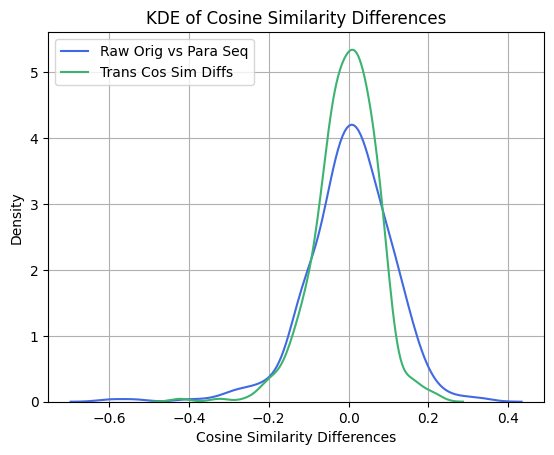

In [339]:
sns.kdeplot(all_raw_cossim_diffs, color='royalblue', label='Raw Orig vs Para Seq')
sns.kdeplot(all_trans_cossim_diffs, color='mediumseagreen', label='Trans Cos Sim Diffs')

plt.title('KDE of Cosine Similarity Differences')
plt.xlabel('Cosine Similarity Differences')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

In [340]:
np.median(all_raw_cossim_diffs)

0.00836277

In [341]:
np.median(all_trans_cossim_diffs )

0.00036656857

In [343]:
np.std(all_trans_cossim_diffs)

0.0776866

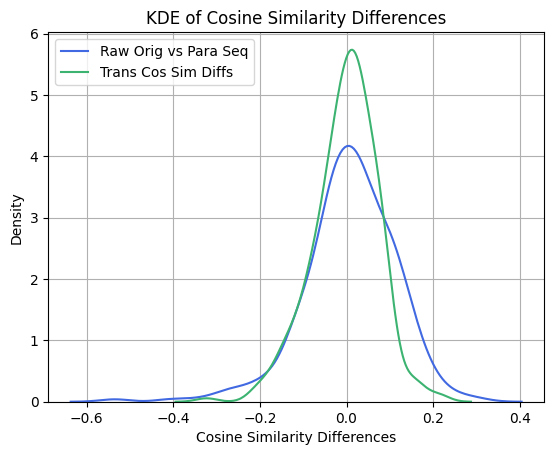

In [344]:
sns.kdeplot(train_raw_cossim_diffs, color='royalblue', label='Raw Orig vs Para Seq')
sns.kdeplot(train_trans_cossim_diffs, color='mediumseagreen', label='Trans Cos Sim Diffs')

plt.title('KDE of Cosine Similarity Differences')
plt.xlabel('Cosine Similarity Differences')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()